In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from numpy import *
from IPython.html.widgets import *
from IPython.display import display
import matplotlib.pyplot as plt
from IPython.core.display import clear_output

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Backpropagation Exercise

Let's implement the backpropagation algorithm to train a simple neural network with a single hidden layer.

<img src="files/images/Backpropagation/diagram.png" class="image-center" style="margin:auto; width: 330px;"/>

# What is backpropagation?

Previously,the stochastic gradient decent rule for training perceptrons was derived, which can be thought of as a single-layer (linear) neural network.  The backpropagation algorithm is a learning rule that lets us train feed-forward networks with more layers. 

Let's start with the derivation for a 3-layer network.

## Notation

 * Input nodes: $ {\bf x} = (x_1, x_2, ... x_i)$
 * Hidden nodes: $ {\bf z} = (z_1, z_2, ... z_j)$
 * Output nodes: $ {\bf y} = (y_1, y_2, ... y_k)$

The input nodes are connected to the hidden nodes via weights $w_{ij}^{ (h) }$, and hidden nodes to output nodes via $w_{jk}^{ (o) }$.

### 1. Forward propagation

Given a particular input ${\bf x}$, we calculate the value (or **activation**) of a particular hidden node $z_j$ by taking the weighted sum of the inputs with $w^{(h)}_{ij}$ and passing it through an **activation function** $\sigma$:

$$ z_j = \sigma \left( w^{(h)}_{0j} + \sum_i x_i w^{(h)}_{ij} \right)$$

We want to use an activation function that is *nonlinear* (if it was a linear function, multi-layer network will not give us any more modeling power than a linear perceptron). The following is an example activation function that contracts the input to the $(-1, 1)$ range (*sigmoid*):

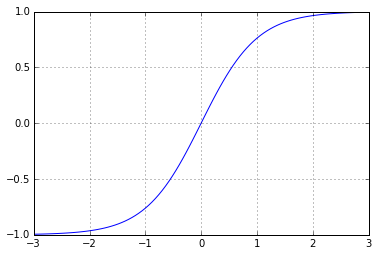

In [2]:
xs=linspace(-3,3,100)
plt.plot(xs,tanh(xs)); plt.grid()

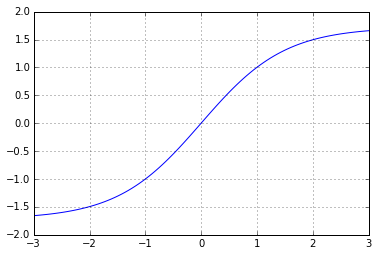

In [3]:
def funny_tanh(x):
    return 1.7159 * tanh(x*2/3) + 0.001 * x

xs=linspace(-3,3,100)
plt.plot(xs,funny_tanh(xs)); plt.grid()

Note that we may want to use the "funny tanh" function instead, because (a) $f(\pm 1) = \pm 1$, (b) the second derivative is a maximum at $x=1$, and (c) the effective gain (change in the variance) is close to 1.  (LeCun, 2012). Here we see that the function indeed keeps the effective gain closer to 1, compared to a regular `tanh`:

In [4]:
from numpy.random import standard_normal
X=standard_normal(10000)
print("X.std() is %f" % X.std()) # should be close to 1
print("tanh(X).std() is %f" % tanh(X).std())
print("funny_tanh(X).std() is %f" % funny_tanh(X).std())

X.std() is 0.990666
tanh(X).std() is 0.629629
funny_tanh(X).std() is 0.867948


Using the vector notation, we can calculate all values of the hidden nodes at once.  Given a $1 \times (I+1)$ row vector of input nodes (for a particular sample) and $(I+1) \times J$ weight matrix $W^{(h)}$,

$$ {\bf z} = \sigma( {\bf x} \cdot W^{(h)} ) $$

The vector ${\bf x}$ has $I + 1$ elements (with the first element always $1$ and the rest being the input vector) in order to take care of the $w^{(h)}_{0j}$ term earlier.  This is called the **bias term**.

Similarly, the values of the output nodes are calculated as

$$ {\bf y} = \sigma( {\bf z} \cdot W^{(o)} ) $$

Here, $W^{(o)}$ is a $(J + 1) \times K$ matrix.

By using the above equations, we can calcuate what the values of the hidden and output nodes should be for each input vector ${\bf x}$. Since the values are propagated from the input to the output, this is called the **feed-foward calculation**.

Note: we can perform the vector-matrix multiplication in `numpy` using the `dot` function, e.g. `dot(x, Wh)`.  Also, we can do the exact same thing for $N$ samples all at once by passing in $N \times (I+1)$ matrix of input nodes using this operation.

Exercise 1. Implement the feed-forward calculation.  Use the activation function $\sigma()$ passed in as the `activation_function` parameter.

For convenience (as we'll see later), let's also output the "raw" values ${\hat {\bf z}}$ and ${\hat {\bf y}}$, which are the activation values before it's passed onto the activation function:

$$ {\hat {\bf z}} = {\bf x} \cdot W^{(h)} , \quad {\bf z} = \sigma( {\hat {\bf z}}) \\ 
{\hat {\bf y}} =  {\bf z} \cdot W^{(o)} , \quad {\bf y} = \sigma( {\hat {\bf y}} )$$

In [5]:
def with_bias(x):
    return c_[ones((x.shape[0], 1)), x]

def activations_for(x, Wh, Wo, activation_function=tanh):
    """Calculates the activations for the hidden and output nodes. (Feed-forward phase)
    
    inputs:
        x: N x I matrix, where each row is a particular observation.
        Wh: I+1 x J matrix of hidden weights.
        Wo: J+1 x K matrix of output weights.
        activation_function: the activation function to use.
    
    returns:
        z: N x J matrix of hidden activations.
        y: N x K matrix of output activations.
        z_raw: N x J matrix of "raw" hidden activations.    
        y_raw: N x K matrix of "raw" output activations.
    """
    z_raw = dot(with_bias(x), Wh)
    z = activation_function(z_raw)
    y_raw = dot(with_bias(z), Wo)
    y = activation_function(y_raw)
    return z, y, z_raw, y_raw

### 2. Backward propagation

We then calculate "errors" associated with each node in the network.  This is called the **backward propagation** phase.
 
As was in the perceptron, the goal of the training is to change the weights $W^{(h)}, W^{(o)}$ so that the current output ${\bf y}$ will be closer to the target values ${\bf t}$.  For the squared error loss, we have

$$ E = \frac{1}{2} ({\bf t} - {\bf y})^\intercal ({\bf t} - {\bf y}) = \frac{1}{2} \sum_{k=1}^{K} (t_k - y_k)^2 $$

First, we want to consider how we should change the weights $w_{jk}^{(o)}$ in order to minimize the loss. 

To do this, let's write the partial derivative of $E$ with respect to a single weight $w_{jk}^{(o)}$. 

Note that this only depends on the output $y_k$, so the sum disappears:

$$
\begin{align*}
\frac{\partial E}{\partial w_{jk}^{(o)}} &= \frac{1}{2} \cdot \frac{\partial (t_k - y_k)^2}{\partial w_{jk}^{(o)}} \\
 &= (t_k-y_k) \frac{\partial (t_k-y_k)} {\partial w_{jk}^{(o)}} \\
&= (y_k - t_k) \frac{\partial y_k}{\partial w_{jk}^{(o)}} \\
&= (y_k - t_k) \sigma'({\hat y}_k) \frac{\partial {\hat y}_k} {\partial w_{jk}^{(o)}} \\
&= \underbrace{(y_k - t_k) \sigma'({\hat y}_k)}_{\delta^{(o)}_k}  \cdot z_j \\
&= \delta^{(o)}_k z_j
\end{align*}
$$

So, the partial derivative has been broken down to the "error" term $\delta^{(o)}_k = \partial E / \partial {\hat y}_k$ that depends on the output node $k$ and the hidden node activation $z_j$.

Again, we can concisely express all partial calculations for $W^{(o)}$ using the matrix form:

$$ \frac{\partial E}{\partial W^{(o)}} =  {\bf z}^\intercal \cdot \delta^{(o)}, \quad \delta^{(o)} = ({\bf y} - {\bf t}) \times \sigma'({\hat {\bf y}})  $$

Here, $\times$ is the element-wise multiplication, yielding $1 \times K$ vector $\delta^{(o)}$.

We can do the same thing for the hidden weights $w_{ij}^{(h)}$. Note that, now, the value of the hidden node $z_j$ does depend on all outputs $y_k$:

$$
\begin{align*}
\frac{\partial E}{\partial w_{ij}^{(h)}} &= \sum_{k=1}^K \left( \frac{\partial E}{\partial {\hat y}_k} \cdot \frac{\partial {\hat y}_k}{\partial z_j} \right) \frac{\partial z_j}{\partial w_{ij}^{(h)}} \\
&= \sum_{k=1}^K \left( \delta^{(o)}_k w^{(o)}_{jk} \right) \cdot \sigma'({\hat z}_j) \cdot x_i
\end{align*}
$$

$$
\frac{\partial E}{\partial W^{(h)}} =  {\bf x}^\intercal \cdot \delta^{(h)}, \quad \delta^{(h)} = ({\hat W}^{(o)} \cdot \delta^{(o)})^\intercal \times \sigma' ({\hat {\bf z}}) 
$$

Here, ${\hat W}^{(o)}$ is the $J \times K$ submatrix of $W^{(o)}$ without the entries corresponding to the bias term.

It looks a bit hairy, but it's conceptually simple:

 * For the output units, the partial derivative is positive (and proportional to) how much my prediction $y_k$ overshot the target $t_k$.
 * For the hidden units, the error is a *sum* of all the output unit errors it's connected to (*not* the input units).  
 
Operationally, we just need to calculate the $\delta^{(o)}$ using the prediction errors and the raw output activations, then calculate $\delta^{(h)}$ using the $\delta^{(o)}$.  Since we calculate the delta values starting from the output nodes and then back, this is called the **backward error propagation**.

The following diagram (taken from Bishop's PRML book) shows the flow of information in the forward propagation (blue arrows) and the backward propagation (red arrows).

<img src="files/images/Backpropagation/diagram2.png" class="image-center" style="width: 300px;"/>

Exercise 2: implement the routine to calculate the delta values. Again, if you implemented the calculations correctly, it would be automatically extended to the calculation for all $N$ samples at once:

$$
\begin{align*}
    \delta^{(o)} &= \underbrace{({\bf y} - {\bf t})}_{N \times K} \times \underbrace{\sigma'({\hat {\bf y}})}_{N \times K} \\
    \delta^{(h)} &= \underbrace{(\delta^{(o)} \cdot {\hat W}^{(o)\intercal})}_{N \times J} \times \underbrace{\sigma' ({\hat {\bf z}})}_{N \times J}
\end{align*}
$$


In [6]:
def approximate_derivative(f, x):
    """Return the (first-order) approximation of the derivative of f at x.
    Of course, we can just use the symbolic derivatives for the activation_function too.
    """
    epsilon=1e-8
    return (f(x+epsilon) - f(x)) / epsilon

def deltas_for(t, z, y, z_raw, y_raw, Wh, Wo, activation_function=tanh):
    """Calculates the delta values for the output and hidden nodes.
    
    inputs:
        t: N x K matrix of target values.
        For other parameters, see "activations_for" function.
    
    returns:
        dh: N x J matrix of deltas for the hidden nodes.
        do: N x K matrix of deltas for the output nodes.
    """
    sigma_prime = lambda x: approximate_derivative(activation_function, x)  # derivative of the activation
    do = multiply(y - t, sigma_prime(y_raw))
    dh = multiply(dot(do, Wo[1:].T), sigma_prime(z_raw))
    return dh, do

### 3. Weight update phase

With $\delta^{(o)}$ and $\delta^{(h)}$, we can update the weights  using stochastic gradient descent:

$$
 W^{(o)} \leftarrow W^{(o)} - \eta \frac{\partial E}{\partial W^{(o)}} = W^{(o)} - \eta ({\bf z}^\intercal \cdot \delta^{(o)}) \\
 W^{(h)} \leftarrow W^{(h)} - \eta \frac{\partial E}{\partial W^{(h)}} = W^{(h)} - \eta ({\bf x}^\intercal \cdot \delta^{(h)})
$$

Note that the amount the weight changes is also modulated by the activation of the nodes connected below: if a node had a large activation, weights associated with it (in the forward propagation) is changed by a large amount, too. 

Exercise 3. Implement the routine to update the weights using the gradient descent.

We can do the updates one sample observation ${\bf x}$ at a time (online learning), or just use the average of the delta values (batch learning). For the batch learning, the update rule would be:

$$
\begin{align*}
 \underbrace{W^{(o)}}_{(J+1) \times K} &\leftarrow W^{(o)} - \frac{\eta}{N} \left( \underbrace{{\bf z}^\intercal}_{(J+1) \times N} \cdot \underbrace{\delta^{(o)}}_{N \times K} \right) \\
 \underbrace{W^{(h)}}_{(I+1) \times J} &\leftarrow W^{(h)} - \frac{\eta}{N} \left( \underbrace{{\bf x}^\intercal}_{(I+1) \times N} \cdot \underbrace{\delta^{(h)}}_{N \times J} \right) \\
\end{align*}
$$

In [7]:
def gradient_descent(do, dh, x, z, Wh, Wo, eta = 0.1):
    """Updates the hidden and output weights using gradient descent and return them.
    
    inputs:
        do: N x K matrix of deltas for the output nodes.
        dh: N x J matrix of deltas for the hidden nodes.
        x, z, Wo: see "activations_for".
        eta: the learning rate to use.
    
    returns:
        updated Wh and Wo.
    """
    N = x.shape[0]
    Wh -= eta / N * dot(with_bias(x).T, dh)
    Wo -= eta / N * dot(with_bias(z).T, do)
    return Wh, Wo

### Putting them all together

Now we just need to put them together and update the weight matrices.

In [8]:
def update_weights(t, x, Wh, Wo, activation_function=tanh, eta=0.1):
    """Updates Wh, Wo and returns them from the traning set x and targets t.
    
    inputs:
        x, Wh, Wo and t.
    
    returns:
        updated Wh and Wo.
    """
    z, y, z_raw, y_raw = activations_for(x, Wh, Wo, activation_function=activation_function)
    dh, do = deltas_for(t, z, y, z_raw, y_raw, Wh, Wo, activation_function=activation_function)
    return gradient_descent(do, dh, x, z, Wh, Wo, eta = eta)

And we will also initialize the weights using the standard Gaussian.

In [9]:
from numpy.random import standard_normal
def initialize_weights(I, J, K):
    """Generates initial hidden and output weights.
    
    inputs:
        I: number of input units.
        J: number of hidden units.
        K: number of output units.
    
    returns:
        Wh: (I+1) x J matrix
        Wo: (J+1) x K matrix
    """
    Wh = standard_normal((I + 1, J))
    Wo = standard_normal((J + 1, K))
    return Wh, Wo

We also want to keep track of the network training.  To do this, we evaluate both the per-sample average of the squared loss ($E$) and the classification error.  To calculate the latter, we first take the sign of the network outputs - these are the *predictions* of the network - and compare them to the target vector ${\bf t}$.  For each sample, the binary error is simply the average of the number of outputs with the incorrect signs.

In [10]:
def errors_for(t, y):
    """Make predictions using the network weights Wh, Wo and 
    compute the average squared loss and the binary loss.
    
    inputs:
        t: N x I matrix of target values.
        y: N x I matrix of output activations.
    
    returns:
        mse: N x 1 vector of mean squared errors
        mbe: N x 1 vector of mean binary errors
    """
    mse = ((y-t)**2).mean()
    mbe = (sign(y) != sign(t)).mean()
    return mse, mbe

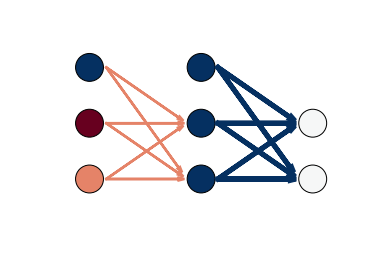

In [11]:
"""Some plotting support functions."""

def plot_errors(ax, epoch, epochs, errors, ylabel='', ylim=1.0):
    """Plots the error graph."""
    ax.plot(arange(epoch), errors[:epoch])
    ax.set_xlim([0, epochs])
    ax.set_ylim([0, ylim])
    ax.set_xlabel("Training epoch")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.grid()

    
def plot_network(ax, x, z, y, Wh, Wo):
    """Plots the graph representation of the network."""
    cmap = plt.get_cmap('RdBu')

    for l, z in enumerate([x, z, y]):
        for i, zi in enumerate(with_bias(z).T):
            if l < 2 or i > 0: # Don't show bias node for the output layer
                ax.add_artist(plt.Circle((1 + l*2, -i-1), 0.25, ec='k', fc=cmap(zi[0]/2+.5)))

    for l, W in enumerate([Wh, Wo]):
        for i, wi in enumerate(W):
            for j, wij in enumerate(wi):
                ax.arrow(1.3 + l*2, -i-1, 1.3, (i-j-1)*.9, head_width=0.05, head_length=0.1, ec=cmap(wij/2+.5), lw=abs(wij)*5.0)

    m = max([x.shape[1], z.shape[1], y.shape[1]])+1
    ax.set_xlim([0, 2*3])
    ax.set_ylim([-m-1,0])
    ax.set_aspect('equal')
    ax.axis('off')

# Example:
fig0, ax = plt.subplots() 
plot_network(ax, array([[-1,-0.5]]), ones((1,2)), zeros((1,2)), -ones((3,2))*0.5,  ones((3, 2)))

def plot_training(epoch, epochs, errors, x, z, y, t, Wh, Wo):
    if epoch is None:
        return

    fig, axs = plt.subplots(1,3,figsize=(15,5))
    aerrors=array(errors).T
    plot_network(axs[0], x, z, y, Wh, Wo)
    plot_errors(axs[1], epoch, epochs, aerrors[0], ylabel='RMSE', ylim=3.0)
    plot_errors(axs[2], epoch, epochs, aerrors[1], ylabel='RMBE', ylim=1.0)
    clear_output(wait=True)

    # Print what's going on
    print('epoch %d / %d' % (epoch + 1, epochs))
    print('x: %s' % str(x))
    print('t: %s' % str(t))


### Training Example

Let's try training it to recognize the "XOR" pattern, and watch how it modifies the weights.  Since the output is not a linear function of the input, a linear classifier (perceptron) cannot learn this pattern. Let's see how the 3-layer neural network does.

epoch 900 / 1000
x: [[ 1.  1.]]
t: [[-1.]]


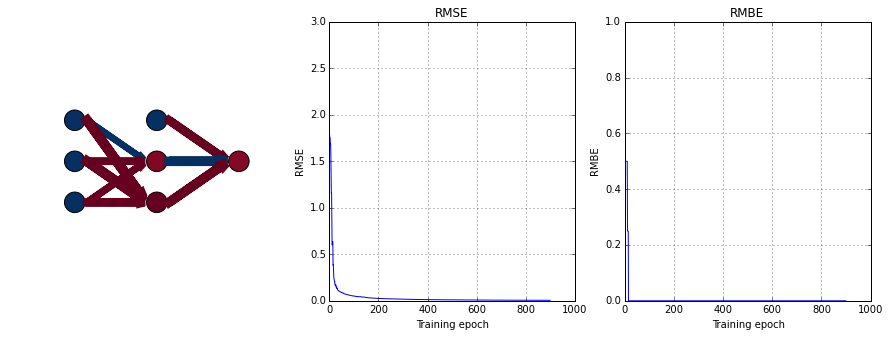

In [21]:
from numpy.random import randint
def train(X, T, J, epochs = 1000, activation_function = tanh, eta = 0.1):
    """Perform online training (one sample at a time)."""
    Wh, Wo = initialize_weights(X.shape[1], J, T.shape[1])
    
    errors = []
    for epoch in range(epochs):
        n = randint(X.shape[0])
        t = T[n, newaxis]
        x = X[n, newaxis]
        Wh, Wo = update_weights(t, x, Wh, Wo, activation_function=activation_function, eta = eta)

        # Evaluate on all targets
        Z, Y, _, _ = activations_for(X, Wh, Wo, activation_function=activation_function)
        z = Z[n, newaxis]
        y = Y[n, newaxis]
        errors.append(errors_for(T, Y))

        # Yield to outside
        yield epoch, epochs, errors, x, z, y, t, Wh, Wo
        

# The XOR pattern
XOR_X=array([
    [ 1,-1],
    [-1, 1],
    [ 1, 1],
    [-1,-1]], dtype=float)
XOR_T=array([
    [ 1],
    [ 1],
    [-1],
    [-1]], dtype=float)

training = train(XOR_X, XOR_T, J = 2, epochs = 1000) # 1000 epochs is usually more than enough (unless it gets stuck)

step1_button = Button(description="Train for one iteration") # Button to perform one iteration
step1_button.on_click(lambda b: plot_training(*next(training, (None,)*8)))
display(step1_button)

step100_button = Button(description="Train for 100 iterations") # Button to perform 100 iterations
step100_button.on_click(lambda b: [next(training, True) for i in range(1,100)] and plot_training(*next(training, (None,)*8)))
display(step100_button)

Note that sometimes (often?), the network gets stuck in a local minimum.  Also, the training (squared error) doesn't necessarily go down in a smooth fashion; this can be alleviated by using batch updates (in the next section.)

## Refactoring the routines

Before going further, let's reorganize the training rolutines so that we can more easily make various changes.  First, because there are many variables that are used by all of the routines, we'll collect them into a class called `NeuralNetwork`.  This class will take the network configuration (number of visible / hidden / output nodes) and contains the following methods, among others:

 * `activations_for`
 * `deltas_for`
 * `gradient_descent`
 * `train`  (This will be the main entry point).

Second, we'll change the routines so that they can be used for any number of layers $L$.  We'll change the notations too: instead of ${\bf z}$, ${\bf y}$, $W^{(h)}$, and $W^{(o)}$, we'll write

 * ${\bf z}^{(l)}$ - hidden nodes at layer $l$, where $l \in 1 .. L$.  So ${\bf x}$ is ${\bf z}^{(1)}$, and ${\bf y}$ is now ${\bf z}^{(L)}$.
 * $W^{(l)}$ - weights from layer $l$ to $l+1$, where $l \in 1 .. L-1$. $W^{(h)}$ is $W^{(1)}$ and $W^{(o)}$ is $W^{(2)}$.
 
With these notations, we can rewrite the previous equations as follows:

 * **Feed-forward**: ${\bf z}^{(l+1)} = \sigma({\bf z}^{(l)} \cdot W^{(l)})$
 * **Backpropagation**: $\delta^{(L)} = ({\bf y} - {\bf t}) \times \sigma'({\hat {\bf y}}), \quad \delta^{(l-1)} = (\delta^{(l)} \cdot {\hat W}^{(l-1)\intercal} ) \times \sigma' ({\hat {\bf z}}^{(l-1)})$
 * **Weight updates**: $W^{(l)} \leftarrow W^{(l)} - \eta ({\bf z}^{(l) \intercal} \cdot \delta^{(l+1)}) $

Third, we'll use the batch learning for the gradient calculation.  Now, instead of using one sample at a time to calculate the gradient, we'll take the average of the gradients.

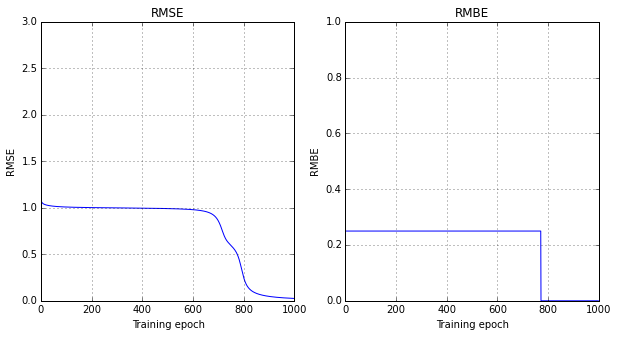

In [18]:
class NeuralNetwork(object):
    def __init__(self, num_nodes=[2,2,1], activation_function=tanh, eta = 0.1):
        self.num_nodes = num_nodes
        self.activation_function = activation_function
        # The derivative
        self.sigma_prime = lambda x: approximate_derivative(self.activation_function, x)
        self.eta = eta
        self.initialize_weights()
    
    def initialize_weights(self):
        self.Ws = [standard_normal((n + 1, m)) for n, m in zip(self.num_nodes[:-1], self.num_nodes[1:])]
    
    def activations_for(self, x):
        """Feed-forward calculations."""
        z_raws = [x]
        zs = [x]
        for W in self.Ws:
            # list[-1] gives the last element on the list.
            z_raws.append(dot(with_bias(zs[-1]), W))
            zs.append(self.activation_function(z_raws[-1]))
        return zs, z_raws
    
    def deltas_for(self, t, zs, z_raws):
        """Calculates the delta values for the output and hidden nodes.
        """
        deltas = [multiply(zs[-1] - t, self.sigma_prime(z_raws[-1]))]
        for W, z_raw in reversed(zip(self.Ws, z_raws)[1:]):
            deltas.append(multiply(dot(deltas[-1], W[1:].T), self.sigma_prime(z_raw)))

        deltas = list(reversed(deltas)) # Keep the lower layer to higher layer order
        return deltas, zs

    def gradient_descent(self, deltas, zs):
        N = zs[0].shape[0]
        return [W - self.eta * dot(with_bias(z).T, delta) / N for W, z, delta in zip(self.Ws, zs[:-1], deltas)]

    def update_weights(self, t, x):
        self.Ws = self.gradient_descent(*self.deltas_for(t, *self.activations_for(x)))

    def predictions_for(self, x):
        zs, _ = self.activations_for(x)
        return zs[-1]
    
    def errors_for(self, t, x):
        y = self.predictions_for(x)
        mse = ((y-t)**2).mean()
        mbe = (sign(y) != sign(t)).mean()
        return mse, mbe

    def train(self, X, T, epochs = 1000):
        """Online training."""
        self.initialize_weights()

        errors = []
        for epoch in range(epochs):
            # Use all data to update weights
            self.update_weights(T, X)
        
            # Evaluate on all targets
            errors.append(self.errors_for(T, X))
            
            # Yield to outside
            yield epoch, epochs, errors

    def plot_network(self, ax, x):
        """Plots the graph representation of the network."""
        cmap = plt.get_cmap('RdBu')
        zs, _ = self.activations_for(x)
        
        for l, z in enumerate(zs):
            for i, zi in enumerate(with_bias(z).T):
                if l < len(zs) - 1 or i > 0: # Don't show bias node for the output layer
                    ax.add_artist(plt.Circle((1 + l*2, -i-1), 0.25, ec='k', fc=cmap(zi[0]/2+.5)))

        for l, W in enumerate(self.Ws):
            for i, wi in enumerate(W):
                for j, wij in enumerate(wi):
                    ax.arrow(1.3 + l*2, -i-1, 1.3, (i-j-1)*.9, head_width=0.05, head_length=0.1, ec=cmap(wij/2+.5), lw=abs(wij)*5.0)
            
        m = max(self.num_nodes)+1
        ax.set_xlim([0, 2*len(self.num_nodes)])
        ax.set_ylim([-m-1,0])
        ax.set_aspect('equal')
        ax.axis('off')
            
    def _plot_errors(self, ax, epoch, epochs, errors, ylabel='', ylim=1.0):
        """Plots the error graph."""
        ax.plot(arange(epoch), errors[:epoch])
        ax.set_xlim([0, epochs])
        ax.set_ylim([0, ylim])
        ax.set_xlabel("Training epoch")
        ax.set_ylabel(ylabel)
        ax.set_title(ylabel)
        ax.grid()
            
    def plot_training(self, epoch, epochs, errors):
        if epoch is None:
            return
        
        fig, axs = plt.subplots(1,2,figsize=(10,5))
        aerrors=array(errors).T
        self._plot_errors(axs[0], epoch, epochs, aerrors[0], ylabel='RMSE', ylim=3.0)
        self._plot_errors(axs[1], epoch, epochs, aerrors[1], ylabel='RMBE', ylim=1.0)
        clear_output(wait=True)

        
net = NeuralNetwork(num_nodes=[XOR_X.shape[1],2,XOR_T.shape[1]])
net_training = net.train(XOR_X, XOR_T, epochs = 1000)

net_train_button = Button(description="Train for 100 iterations") # Button to perform 100 iterations
net_train_button.on_click(lambda b: [next(net_training, True) for i in range(1,100)] and net.plot_training(*next(net_training, (None,)*3)))
display(net_train_button)

After training until satisfaction, plot how the network makes predictions:

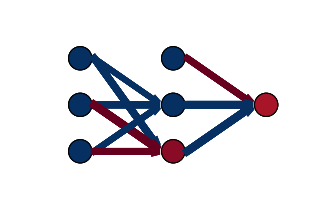

In [19]:
fig1, ax = plt.subplots(figsize=(5,5))
interact(lambda n: net.plot_network(ax, XOR_X[n-1,newaxis]) or display(fig1), 
         n=IntSlider(description='Make predictions for example ',min=1,max=XOR_X.shape[0])); plt.close()

## Example: classifying handwritten digits

Now let's use the `NeuralNetwork` to perform some supervised learning.  For starters, we'll classify handwritten digits data that comes with `scikit-learn`.  We'll use the `OneHotEncoder` to convert target values (0 through 9) into 10 output units, and also use `PCA` to decorrelate the inputs (and reduce the dimensionality for noise reduction.)

We also use the mini-batch training to smooth the gradient estimates.

In [15]:
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split, ShuffleSplit 
from sklearn.preprocessing import OneHotEncoder

class ClassifierNetwork(NeuralNetwork):
    def train(self, X, T, epochs = 1000, test_size = 0.2):
        """Mini-batch training."""
        
        # Prepare the output encoder
        self.encoder = OneHotEncoder(sparse=False).fit(T[:,newaxis])
        T1 = self.encoder.transform(T[:,newaxis])*2-1  # Convert to {-1, 1}
        
        # Split into training and test
        X_train, X_test, T1_train, T1_test = train_test_split(X, T1, test_size=test_size)
        
        # Preprocess the data using PCA
        self.pca = PCA(n_components = self.num_nodes[0], whiten=True, copy=True)
        Xw_train = self.pca.fit_transform(X_train)
        Xw_test = self.pca.transform(X_test)
    
        # Then do the training
        self.initialize_weights()

        train_errors = []
        test_errors = []
        # Use 10% of the training data for each iteration (mini-batch)
        for epoch, (batch_index, _) in enumerate(ShuffleSplit(Xw_train.shape[0], n_iter=epochs, train_size=0.1)):
            self.update_weights(T1_train[batch_index], Xw_train[batch_index])
        
            # Evaluate for training and test sets
            train_errors.append(self.errors_for(T1_train, Xw_train))
            test_errors.append(self.errors_for(T1_test, Xw_test))
            
            # Yield to outside
            yield epoch, epochs, train_errors, test_errors    

    def decode(self, Y):
        """Decodes the output node values back to the target vector."""
        return Y.argmax(axis=1) # Pick the one with the maximum activation
    
    def predictions_for(self, x):
        xw = self.pca.transform(x)
        y = super(ClassifierNetwork, self).predictions_for(xw)
        return self.decode(y)
    
    def errors_for(self, t, x):
        y = super(ClassifierNetwork, self).predictions_for(x)
        mse = multiply(y-t,y-t).mean()
        mce = (self.decode(y) != self.decode(t)).mean()
        return mse, mce

    def plot_training(self, fig, axs, epoch, epochs, train_errors, test_errors):
        if epoch is None:
            return
        
        atrain_errors=array(train_errors).T
        atest_errors=array(test_errors).T
        self._plot_errors(axs[0], epoch, epochs, c_[atrain_errors[0],atest_errors[0]], ylabel='RMSE', ylim=3.0)
        axs[0].legend(['Training', 'Test'], loc="best")
        self._plot_errors(axs[1], epoch, epochs, c_[atrain_errors[1],atest_errors[1]], ylabel='Classification Error', ylim=1.0)
        axs[1].legend(['Training', 'Test'], loc="best") 
        clear_output(wait=True)
        display(fig)
        [ax.cla() for ax in axs]

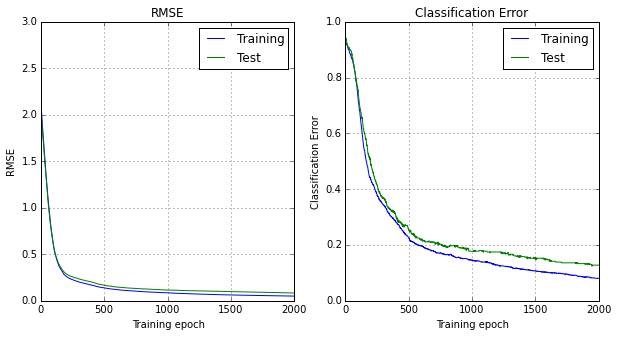

In [16]:
from sklearn.datasets import load_digits
digits = load_digits()
digits_net = ClassifierNetwork(num_nodes=[20,20,10])

fig2, axs = plt.subplots(1,2,figsize=(10,5))
for epoch, epochs, train_errors, test_errors in digits_net.train(digits.data, digits.target, epochs=2000):
    if mod(epoch+1, 100) == 0:
        digits_net.plot_training(fig2, axs, epoch, epochs, train_errors, test_errors)
plt.close()

Let's see where the network made incorrect classifications.

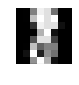

Target = 8, Prediction = 7


In [20]:
fig3, ax = plt.subplots(figsize=(1,1))
Y = digits_net.predictions_for(digits.data)
incorrect = flatnonzero(Y != digits.target)

@interact
def plot_digits_predictions(n=(0, len(incorrect)-1)):
    image_id = incorrect[n]
    ax.imshow(digits.images[image_id], cmap='gray', interpolation='none')
    ax.axis('off')
    clear_output(wait=True)
    display(fig3)
    print('Target = %d, Prediction = %d' % (digits.target[image_id], Y[image_id]))
plt.close()

Incorrectly classified digits tend to be some of the more ambiguous ones.